In [ ]:
!pip install datasets

import torch
from torch import nn
from torch.nn import functional as F
from transformers import GPT2Tokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader

import tqdm
import numpy as np
import pdb

device = torch.device("cuda")

In [ ]:
NEG_INF = 1e-9

In [ ]:
"""
From XPOS...
"""

# Copyright (c) 2022 Microsoft
# Licensed under The MIT License (https://github.com/microsoft/torchscale/blob/main/LICENSE)
import torch
import torch.nn as nn

def fixed_pos_embedding(x):
    seq_len, dim = x.shape
    inv_freq = 1.0 / (10000 ** (torch.arange(0, dim) / dim))
    sinusoid_inp = (
        torch.einsum("i , j -> i j", torch.arange(0, seq_len, dtype=torch.float), inv_freq).to(x)
    )
    return torch.sin(sinusoid_inp), torch.cos(sinusoid_inp)

def rotate_every_two(x):
    x1 = x[:, :, ::2]
    x2 = x[:, :, 1::2]
    x = torch.stack((-x2, x1), dim=-1)
    if x.shape[-1]%2 == 1:
        # fill last dim with zero if hidden_size is odd
        x2 = torch.concat((x2, torch.zeros_like(x2[:, :, :1])), dim=-1)
    return x.flatten(-2)  # in einsum notation: rearrange(x, '... d j -> ... (d j)')\

def duplicate_interleave(m):
    """
    A simple version of `torch.repeat_interleave` for duplicating a matrix while interleaving the copy.
    """
    dim0 = m.shape[0]
    m = m.view(-1, 1)  # flatten the matrix
    m = m.repeat(1, 2)  # repeat all elements into the 2nd dimension
    m = m.view(dim0, -1)  # reshape into a matrix, interleaving the copy
    return m

def apply_rotary_pos_emb(x, sin, cos, scale=1):
    sin, cos = map(lambda t: duplicate_interleave(t * scale), (sin, cos))
    # einsum notation for lambda t: repeat(t[offset:x.shape[1]+offset,:], "n d -> () n () (d j)", j=2)
    return (x * cos[:, :x.shape[-1]]) + (rotate_every_two(x) * sin)[:, :, :x.shape[-1]]


class XPOS(nn.Module):
    def __init__(
        self, head_dim, scale_base=512
    ):
        super().__init__()
        self.head_dim = head_dim
        self.scale_base = scale_base
        self.register_buffer(
            "scale", (torch.arange(0, head_dim, 2) + 0.4 * head_dim) / (1.4 * head_dim)
        )

    def forward(self, x, offset=0, downscale=False):
        length = x.shape[1]
        min_pos = 0
        max_pos = length + offset + min_pos
        scale = self.scale ** torch.arange(min_pos, max_pos, 1).to(self.scale).div(self.scale_base)[:, None]
        sin, cos = fixed_pos_embedding(scale)

        if scale.shape[0] > length:
            scale = scale[-length:]
            sin = sin[-length:]
            cos = cos[-length:]

        if downscale:
            scale = 1 / scale

        x = apply_rotary_pos_emb(x, sin, cos, scale)
        return x

    def forward_reverse(self, x, offset=0, downscale=False):
        length = x.shape[1]
        min_pos = -(length + offset) // 2
        max_pos = length + offset + min_pos
        scale = self.scale ** torch.arange(min_pos, max_pos, 1).to(self.scale).div(self.scale_base)[:, None]
        sin, cos = fixed_pos_embedding(scale)

        if scale.shape[0] > length:
            scale = scale[-length:]
            sin = sin[-length:]
            cos = cos[-length:]

        if downscale:
            scale = 1 / scale

        x = apply_rotary_pos_emb(x, -sin, cos, scale)
        return x


In [ ]:
class AttentionHead(nn.Module):
    def __init__(self, input_size, hidden_size, rope=False):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sqrt_hidden_size = np.sqrt(hidden_size)

        self.linear_Q = nn.Linear(input_size, hidden_size)
        self.linear_K = nn.Linear(input_size, hidden_size)
        self.linear_V = nn.Linear(input_size, hidden_size)

        if rope:
            self.xpos = XPOS(hidden_size)
        else:
            self.xpos = nn.Identity()

    def forward(self, input, mask):
        """
        Input has shape (batch_size, MAX_SEQ_LENGTH, input_size)
        """
        batch_size, seq_length, _ = input.shape

        # TODO
        # use @cache

        queries = self.linear_Q(input)
        keys = self.linear_K(input)
        values = self.linear_V(input)

        queries = self.xpos(queries)
        keys = self.xpos(keys)

        scores = (queries @ keys.transpose(1, 2)) / self.sqrt_hidden_size
        scores = scores.masked_fill(mask == 0, NEG_INF)

        probs = F.softmax(scores, dim=-1)
        output = probs @ values

        return output

class MultiHeadedAttention(nn.Module):
    def __init__(self, hidden_size, num_heads, rope=False):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_heads = num_heads

        self.heads = nn.ModuleList([
            AttentionHead(hidden_size, int(hidden_size / num_heads), rope=rope)
            for _ in range(num_heads)
        ])

        self.proj = nn.Linear(hidden_size, hidden_size)

    def forward(self, input, mask):
        """
        Input has shape (batch_size, MAX_SEQ_LENGTH, input_size)
        """
        return self.proj(torch.concat([head(input, mask) for head in self.heads], dim=-1))

In [ ]:
import math

class SimpleRetention(nn.Module):
    def __init__(self, hidden_size, gamma, head_size=None, double_v_dim=False):
        """
        Simple retention mechanism based on the paper
        "Retentive Network: A Successor to Transformer for Large Language Models"[https://arxiv.org/pdf/2307.08621.pdf]
        """
        super(SimpleRetention, self).__init__()

        self.hidden_size = hidden_size
        if head_size is None:
            head_size = hidden_size
        self.head_size = head_size

        self.v_dim = head_size * 2 if double_v_dim else head_size
        self.gamma = gamma

        self.W_Q = nn.Parameter(torch.randn(hidden_size, head_size) / hidden_size)
        self.W_K = nn.Parameter(torch.randn(hidden_size, head_size) / hidden_size)
        self.W_V = nn.Parameter(torch.randn(hidden_size, self.v_dim) / hidden_size)

        self.xpos = XPOS(head_size)

    def forward(self, X):
        """
        Parallel (default) representation of the retention mechanism.
        X: (batch_size, sequence_length, hidden_size)
        """
        sequence_length = X.shape[1]
        D = self._get_D(sequence_length).to(X.device)

        Q = (X @ self.W_Q)
        K = (X @ self.W_K)

        Q = self.xpos(Q)
        K = self.xpos(K, downscale=True)

        V = X @ self.W_V
        ret = (Q @ K.permute(0, 2, 1)) * D.unsqueeze(0)

        return ret @ V

    def forward_recurrent(self, x_n, s_n_1, n):
        """
        Recurrent representation of the retention mechanism.
        x_n: (batch_size, 1, hidden_size)
        s_n_1: (batch_size, hidden_size, v_dim)
        """

        Q = (x_n @ self.W_Q) # batch_size, 1, head_size
        K = (x_n @ self.W_K)

        Q = self.xpos(Q, n+1)
        K = self.xpos(K, n+1, downscale=True)

        V = x_n @ self.W_V

        # K: (batch_size, 1, hidden_size)
        # V: (batch_size, 1, v_dim)
        # s_n = gamma * s_n_1 + K^T @ V
        # pdb.set_trace()

        s_n = self.gamma * s_n_1 + (K.transpose(-1, -2) @ V)

        return (Q @ s_n), s_n

    def forward_chunkwise(self, x_i, r_i_1, i):
        """
        Chunkwise representation of the retention mechanism.
        x_i: (batch_size, chunk_size, hidden_size)
        r_i_1: (batch_size, hidden_size, v_dim)
        """
        batch, chunk_size, _ = x_i.shape
        D = self._get_D(chunk_size).to(x_i.device)

        Q = (x_i @ self.W_Q)
        K = (x_i @ self.W_K)

        Q = self.xpos(Q, i * chunk_size)
        K = self.xpos(K, i * chunk_size, downscale=True)

        V = x_i @ self.W_V

        r_i =(K.transpose(-1, -2) @ (V * D[-1].view(1, chunk_size, 1))) + (self.gamma ** chunk_size) * r_i_1

        inner_chunk = ((Q @ K.transpose(-1, -2)) * D.unsqueeze(0)) @ V

        #e[i,j] = gamma ** (i+1)
        e = torch.zeros(batch, chunk_size, 1)

        for _i in range(chunk_size):
            e[:, _i, :] = self.gamma ** (_i + 1)

        cross_chunk = (Q @ r_i_1) * e

        return inner_chunk + cross_chunk, r_i

    def _get_D(self, sequence_length):
        n = torch.arange(sequence_length).unsqueeze(1)
        m = torch.arange(sequence_length).unsqueeze(0)

        # Broadcast self.gamma ** (n - m) with appropriate masking to set values where n < m to 0
        D = (self.gamma ** (n - m)) * (n >= m).float()  #this results in some NaN when n is much larger than m
        # fill the NaN with 0
        D[D != D] = 0

        return D



class MultiScaleRetention(nn.Module):
    def __init__(self, hidden_size, heads, double_v_dim=False):
        """
        Multi-scale retention mechanism based on the paper
        "Retentive Network: A Successor to Transformer for Large Language Models"[https://arxiv.org/pdf/2307.08621.pdf]
        """
        super(MultiScaleRetention, self).__init__()
        self.hidden_size = hidden_size
        self.v_dim = hidden_size * 2 if double_v_dim else hidden_size
        self.heads = heads
        assert hidden_size % heads == 0, "hidden_size must be divisible by heads"
        self.head_size = hidden_size // heads
        self.head_v_dim = hidden_size * 2 if double_v_dim else hidden_size

        self.gammas = (1 - torch.exp(torch.linspace(math.log(1/32), math.log(1/512), heads))).detach().cpu().tolist()

        self.swish = lambda x: x * torch.sigmoid(x)
        self.W_G = nn.Parameter(torch.randn(hidden_size, self.v_dim) / hidden_size)
        self.W_O = nn.Parameter(torch.randn(self.v_dim, hidden_size) / hidden_size)
        self.group_norm = nn.GroupNorm(heads, self.v_dim)

        self.retentions = nn.ModuleList([
            SimpleRetention(self.hidden_size, gamma, self.head_size, double_v_dim) for gamma in self.gammas
        ])

    def forward(self, X):
        """
        parallel representation of the multi-scale retention mechanism
        """

        # apply each individual retention mechanism to X
        Y = []
        for i in range(self.heads):
            Y.append(self.retentions[i](X))

        Y = torch.cat(Y, dim=2)
        Y_shape = Y.shape
        Y = self.group_norm(Y.reshape(-1, self.v_dim)).reshape(Y_shape)

        return (self.swish(X @ self.W_G) * Y) @ self.W_O

    def forward_recurrent(self, x_n, s_n_1s, n):
        """
        recurrent representation of the multi-scale retention mechanism
        x_n: (batch_size, 1, hidden_size)
        s_n_1s: (batch_size, heads, hidden_size, head_size)

        """

        # apply each individual retention mechanism to a slice of X
        Y = []
        s_ns = []
        for i in range(self.heads):
            y, s_n = self.retentions[i].forward_recurrent(
                x_n[:, :, :], s_n_1s[:,i], n
                )
            Y.append(y)
            s_ns.append(s_n)

        Y = torch.cat(Y, dim=2)
        Y_shape = Y.shape
        Y = self.group_norm(Y.reshape(-1, self.v_dim)).reshape(Y_shape)

        return (self.swish(x_n @ self.W_G) * Y) @ self.W_O, s_ns

    def forward_chunkwise(self, x_i, r_i_1s, i):
        """
        chunkwise representation of the multi-scale retention mechanism
        x_i: (batch_size, chunk_size, hidden_size)
        r_i_1s: (batch_size, heads, head_size, head_size)
        """
        batch, chunk_size, _ = x_i.shape

        # apply each individual retention mechanism to a slice of X
        Y = []
        r_is = []
        for j in range(self.heads):
            y, r_i = self.retentions[j].forward_chunkwise(
                x_i[:, :, :], r_i_1s[j], i
                )
            Y.append(y)
            r_is.append(r_i)


        Y = torch.cat(Y, dim=2)
        Y_shape = Y.shape
        Y = self.group_norm(Y.reshape(-1, self.v_dim)).reshape(Y_shape)

        return (self.swish(x_i @ self.W_G) * Y) @ self.W_O, r_is

In [ ]:
class hybrid_retention(nn.Module):
    def __init__(self, hidden_size, heads, num_attn):
        super().__init__()
        self.hidden_size = hidden_size
        self.heads = heads
        self.num_attn = num_attn
        self.num_retn = heads - num_attn

        assert(hidden_size % heads == 0)
        self.head_size = hidden_size // heads


        self.retn_size = self.num_retn * self.head_size
        self.attn_size = self.num_attn * self.head_size

        self.retn_proj = nn.Linear(hidden_size, self.retn_size)
        self.attn_proj = nn.Linear(hidden_size, self.attn_size)

        self.retns = MultiScaleRetention(self.retn_size, self.num_retn)
        self.attns = MultiHeadedAttention(self.attn_size, self.num_attn, rope=True)

        self.proj = nn.Linear(hidden_size, hidden_size)

    def forward(self, x, mask):
        retns = self.retns(self.retn_proj(x))
        attns = self.attns(self.attn_proj(x), mask)

        out = torch.concat([retns, attns], dim=-1)
        return self.proj(out)

In [ ]:
class ZombieRetformer(nn.Module):
    def __init__(self, layers, hidden_dim, ffn_size, heads, vocab_size, dropout, num_attn):
        super().__init__()
        self.vocab_size = vocab_size
        self.layers = layers
        self.hidden_dim = hidden_dim
        self.ffn_size = ffn_size
        self.heads = heads
        self.num_attn = num_attn

        self.embed = nn.Embedding(vocab_size, hidden_dim)
        self.proj = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", None)
        self.attentions = nn.ModuleList([
            hybrid_retention(hidden_dim, heads, num_attn)
            for _ in range(layers)
        ])
        self.ffns = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, ffn_size),
                nn.GELU(),
                nn.Linear(ffn_size, hidden_dim)
            )
            for _ in range(layers)
        ])
        self.layer_norms_1 = nn.ModuleList([
            nn.LayerNorm(hidden_dim)
            for _ in range(layers)
        ])
        self.layer_norms_2 = nn.ModuleList([
            nn.LayerNorm(hidden_dim)
            for _ in range(layers)
        ])
        self.mask = None

    def forward(self, X):
        """
        X: (batch_size, sequence_length, hidden_size)
        """
        X = self.embed(X)
        if self.mask is None or self.mask.shape[0] != X.shape[1]:
            self.mask = torch.ones(X.shape[1], X.shape[1]).tril().to(X.device)
        for i in range(self.layers):
            Y = self.attentions[i](self.layer_norms_1[i](X), self.mask)
            Y = self.dropout(Y)
            Y = Y + X
            Z = self.ffns[i](self.layer_norms_2[i](Y))
            Z = self.dropout(Z)
            X = Z + Y
        X = self.dropout(X)
        X = self.proj(X)
        return X

In [ ]:
class Retformer(nn.Module):
    def __init__(self, layers, hidden_dim, ffn_size, heads, vocab_size, dropout, binary_vector):
        super().__init__()
        self.vocab_size = vocab_size
        self.layers = layers
        self.hidden_dim = hidden_dim
        self.ffn_size = ffn_size
        self.heads = heads
        # self.num_attn = num_attn

        self.embed = nn.Embedding(vocab_size, hidden_dim)
        self.proj = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", None)
        self.binary_vector = binary_vector

        self.attentions = nn.ModuleList([
            MultiHeadedAttention(hidden_dim, heads, rope=True) if binary_vector[i] == '0' else MultiScaleRetention(hidden_dim, heads)
            for i in range(layers)
        ])
        self.ffns = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, ffn_size),
                nn.GELU(),
                nn.Linear(ffn_size, hidden_dim)
            )
            for _ in range(layers)
        ])
        self.layer_norms_1 = nn.ModuleList([
            nn.LayerNorm(hidden_dim)
            for _ in range(layers)
        ])
        self.layer_norms_2 = nn.ModuleList([
            nn.LayerNorm(hidden_dim)
            for _ in range(layers)
        ])
        self.mask = None

    def forward(self, X):
        """
        X: (batch_size, sequence_length, hidden_size)
        """
        return self.forward_efficient_typeB(X)
        # X = self.embed(X)
        # if self.mask is None or self.mask.shape[0] != X.shape[1]:
        #     self.mask = torch.ones(X.shape[1], X.shape[1]).tril().to(X.device)
        # for i in range(self.layers):
        #     Y = self.attentions[i](self.layer_norms_1[i](X), self.mask) if self.binary_vector[i] == '0' else self.attentions[i](self.layer_norms_1[i](X))
        #     Y = self.dropout(Y)
        #     Y = Y + X
        #     Z = self.ffns[i](self.layer_norms_2[i](Y))
        #     Z = self.dropout(Z)
        #     X = Z + Y
        # X = self.dropout(X)
        # X = self.proj(X)
        # return X
    def forward_efficient_typeA(self, X):
      """
        Recurrent representation of the retention mechanism.
        x_n: (batch_size, 1, hidden_size)
        s_n_1: (batch_size, heads, hidden_size, v_dim)
        """
        # Y = []
        # s_ns = []
        # for i in range(self.heads):
        #     y, s_n = self.retentions[i].forward_recurrent(
        #         x_n[:, :, :], s_n_1s[i], n
        #         )
        #     Y.append(y)
        #     s_ns.append(s_n)

        # Y = torch.cat(Y, dim=2)
        # Y_shape = Y.shape
        # Y = self.group_norm(Y.reshape(-1, self.v_dim)).reshape(Y_shape)
      # global x_n, s_n_1
      X = self.embed(X)
      if self.mask is None or self.mask.shape[0] != X.shape[1]:
          self.mask = torch.ones(X.shape[1], X.shape[1]).tril().to(X.device)
      i = 0
      while i < self.layers:
        if isinstance(self.attentions[i], MultiScaleRetention): break
        Y = self.attentions[i](self.layer_norms_1[i](X), self.mask) if self.binary_vector[i] == '0' else self.attentions[i](self.layer_norms_1[i](X))
        Y = self.dropout(Y)
        Y = Y + X
        Z = self.ffns[i](self.layer_norms_2[i](Y))
        Z = self.dropout(Z)
        X = Z + Y
        i += 1

      if i < self.layers:
        x_n = torch.rand(X.shape[0],1,self.hidden_dim).to(X.device)

        s_n_1 = torch.rand(X.shape[0], self.heads, self.attentions[i].head_size, self.attentions[i].head_size).to(X.device)
        while i < self.layers:
          # here, we simulate the inference as if we had access to our previously cached x_ns, so we only compute the last one
          # x_ns=[]
          # for j in range(X.shape[1]):
          j = X.shape[1]-1
          x_n, s_n_1 = self.attentions[i].forward_recurrent(x_n,s_n_1,j)
          s_n_1 = torch.stack(s_n_1, dim=1)

          # x_ns.append(x_n)
          Y = torch.cat([x_n for _ in range(X.shape[1])],dim=1).to(X.device)
          # pdb.set_trace()
          Y = self.dropout(Y)
          Y = Y + X
          Z = self.ffns[i](self.layer_norms_2[i](Y))
          Z = self.dropout(Z)
          X = Y + Z
          i += 1
      X = self.proj(X)
      return X
    def forward_efficient_typeB(self, X):
      """
        Recurrent representation of the retention mechanism.
        x_n: (batch_size, 1, hidden_size)
        s_n_1: (batch_size, heads, hidden_size, v_dim)
        """
        # Y = []
        # s_ns = []
        # for i in range(self.heads):
        #     y, s_n = self.retentions[i].forward_recurrent(
        #         x_n[:, :, :], s_n_1s[i], n
        #         )
        #     Y.append(y)
        #     s_ns.append(s_n)

        # Y = torch.cat(Y, dim=2)
        # Y_shape = Y.shape
        # Y = self.group_norm(Y.reshape(-1, self.v_dim)).reshape(Y_shape)
      # global x_n, s_n_1
      X = self.embed(X)
      if self.mask is None or self.mask.shape[0] != X.shape[1]:
          self.mask = torch.ones(X.shape[1], X.shape[1]).tril().to(X.device)
      i = 0
      x_n = torch.rand(X.shape[0],1,self.hidden_dim).to(X.device)
      s_n_1 = torch.rand(X.shape[0], self.heads, self.attentions[i].head_size, self.attentions[i].head_size).to(X.device)

      while i < self.layers:
        if isinstance(self.attentions[i], MultiHeadedAttention): break
        x_ns=[]
        # for j in range(X.shape[1]):
        x_n, s_n_1 = self.attentions[i].forward_recurrent(x_n,s_n_1,X.shape[1]-1)
        s_n_1 = torch.stack(s_n_1, dim=1)
          # x_ns.append(x_n)
        Y = torch.cat([x_n for _ in range(X.shape[1])],dim=1).to(X.device)
        # pdb.set_trace()
        Y = self.dropout(Y)
        Y = Y + X
        Z = self.ffns[i](self.layer_norms_2[i](Y))
        Z = self.dropout(Z)
        X = Y + Z
        i += 1

      while i < self.layers:

        Y = self.attentions[i](self.layer_norms_1[i](X), self.mask) if self.binary_vector[i] == '0' else self.attentions[i](self.layer_norms_1[i](X))
        Y = self.dropout(Y)
        Y = Y + X
        Z = self.ffns[i](self.layer_norms_2[i](Y))
        Z = self.dropout(Z)
        X = Z + Y
        i += 1

      X = self.proj(X)
      return X

In [ ]:
class WikiDataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, CHUNK_SIZE, name='wikitext-2-raw-v1', split='train', length=None):
        self.data = load_dataset('wikitext', name, split=split)
        print("Length of dataset: ", len(self.data['text']))
        self.data = tokenizer("\n\n".join(self.data['text']), return_tensors='pt').input_ids[0]
        print("Shape of tokens dataset: ", self.data.shape)
        self.CHUNK_SIZE = CHUNK_SIZE
        self.length = len(self.data) // self.CHUNK_SIZE if length is None else length
    def __getitem__(self, idx):
        chunk= self.data[idx * self.CHUNK_SIZE:(idx + 1) * self.CHUNK_SIZE]
        return chunk[:-1], chunk[1:]
    def __len__(self):
        return self.length
@torch.no_grad()
def evaluate(model, data_loader, vocab_size, nsamples=40):
    model.eval()
    criterion = nn.CrossEntropyLoss(reduction='mean')
    nll = 0.0
    counter = 0

    with torch.no_grad():
        for x,target in data_loader:
            if counter == nsamples:
                break
            counter += 1
            x,target=x.to(device),target.to(device)
            pred = model(x)
            loss = criterion(pred.view(-1, vocab_size), target.view(-1))
            nll += loss.item()

    return np.exp( nll / (counter))

In [ ]:

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
vocab_size = len(tokenizer)

In [ ]:
def print_num_parameters(model):
  print("Num parameters:",sum(p.numel() for p in model.parameters() if p.requires_grad))

In [ ]:
# printing how many parameters each transformer has
for net_param in range(13):
  net = Retformer(12, 768, 768, 8, vocab_size, 0.2, binary_vector=('0' * net_param + '1' * (12 - net_param)))
  print(f"Type A with {net_param} attention layers has {sum(p.numel() for p in net.parameters() if p.requires_grad)} parameters")
for net_param in range(1, 12):
  net = Retformer(12, 768, 768, 8, vocab_size, 0.2, binary_vector=('1' * net_param + '0' * (12 - net_param)))
  print(f"Type B with {net_param} retention layers has {sum(p.numel() for p in net.parameters() if p.requires_grad)} parameters")
for net_param in range(1,8):
  net = ZombieRetformer(12, 768, 768, 8, vocab_size, 0.2, num_attn=net_param)
  print(f"Type C with {net_param} attention heads has {sum(p.numel() for p in net.parameters() if p.requires_grad)} parameters")

Type A with 0 attention layers has 126863953 parameters
Type A with 1 attention layers has 126275665 parameters
Type A with 2 attention layers has 125687377 parameters
Type A with 3 attention layers has 125099089 parameters
Type A with 4 attention layers has 124510801 parameters
Type A with 5 attention layers has 123922513 parameters
Type A with 6 attention layers has 123334225 parameters
Type A with 7 attention layers has 122745937 parameters
Type A with 8 attention layers has 122157649 parameters
Type A with 9 attention layers has 121569361 parameters
Type A with 10 attention layers has 120981073 parameters
Type A with 11 attention layers has 120392785 parameters
Type A with 12 attention layers has 119804497 parameters
Type B with 1 retention layers has 120392785 parameters
Type B with 2 retention layers has 120981073 parameters
Type B with 3 retention layers has 121569361 parameters
Type B with 4 retention layers has 122157649 parameters
Type B with 5 retention layers has 122745937 

In [ ]:
!pip install wandb
!wandb login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 23.1 MB/s eta 0:00:00
ERROR: Operation cancelled by user
/bin/bash: line 1: wandb: command not found


In [ ]:
SEQ_LENGTH = 128
CHUNK_SIZE = SEQ_LENGTH
BATCH_SIZE = 32
train_set = WikiDataset(tokenizer, CHUNK_SIZE, length=2048)

Length of dataset:  36718


Token indices sequence length is longer than the specified maximum sequence length for this model (2428601 > 1024). Running this sequence through the model will result in indexing errors


Shape of tokens dataset:  torch.Size([2428601])


In [ ]:
!pip install thop

In [ ]:
# here we try working with batch_size BATCH_SIZE or 1

from thop import profile
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE)
for data, target in train_loader:
  break
print(f"{data.shape=}") # batch_size 32
macs_A = []
macs_B=[]
macs_C = []
# printing how many parameters each transformer has
with torch.no_grad():
  for net_param in range(13):
    net = Retformer(12, 768, 768, 8, vocab_size, 0.2, binary_vector=('0' * net_param + '1' * (12 - net_param))).eval()
    macs, params = profile(net, inputs=(data, ))
    macs_A.append(macs // 32)

    # print(f"Type A with {net_param} attention layers has {macs} macs")
  for net_param in range(1, 12):
    net = Retformer(12, 768, 768, 8, vocab_size, 0.2, binary_vector=('1' * net_param + '0' * (12 - net_param))).eval()
    macs, params = profile(net, inputs=(data, ))
    # print(f"Type B with {net_param} retention layers has {macs} macs")
    macs_B.append(macs//32)
  for net_param in range(1,8):
    net = ZombieRetformer(12, 768, 768, 8, vocab_size, 0.2, num_attn=net_param).eval()
    macs, params = profile(net, inputs=(data, ))
    # print(f"Type C with {net_param} attention heads has {macs} macs")
    macs_C.append(macs//32)

data.shape=torch.Size([32, 127])
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.La

In [ ]:
# batch_size = batch_size
[mac / 1e9 for mac in macs_A], [mac / 1e9 for mac in macs_B], [mac / 1e9 for mac in macs_C]

([6.70901376,
  7.008644352,
  7.308274944,
  7.607905536,
  7.907536128,
  8.20716672,
  8.506797312,
  8.806427904,
  9.106058496,
  9.405689088,
  9.70531968,
  10.004950272,
  10.304580864],
 [10.004950272,
  9.70531968,
  9.405689088,
  9.106058496,
  8.806427904,
  8.506797312,
  8.20716672,
  7.907536128,
  7.607905536,
  7.308274944,
  7.008644352],
 [8.562978048,
  8.731520256,
  9.012423936,
  9.405689088,
  9.911315712,
  10.529303808,
  11.259653376])

In [ ]:
"""
recurrent representation of the multi-scale retention mechanism
x_n: (batch_size, 1, hidden_size)
s_n_1s: (batch_size, heads, head_size, head_size)

"""
from thop import profile

# net_param = 1
# net = Retformer(12, 768, 768, 8, vocab_size, 0.2, binary_vector=('0' * net_param + '1' * (12 - net_param))).eval()
# multiscale_attention = net.attentions[0]
# multiscale_retention = net.attentions[1]
# isinstance(multiscale_attention, MultiHeadedAttention),isinstance(multiscale_attention, MultiScaleRetention),isinstance(multiscale_retention, MultiHeadedAttention),isinstance(multiscale_retention, MultiScaleRetention)


In [ ]:
'''
simplretention: s_n_1.shape = 32,768,96

'''
# del data
# del net
torch.cuda.empty_cache()
!nvidia-smi

Mon Dec 11 08:07:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    29W /  70W |    461MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
macs_A

[209510376.0,
 218886024.0,
 228261672.0,
 237637320.0,
 247012968.0,
 256388616.0,
 265764264.0,
 275139912.0,
 284515560.0,
 293891208.0,
 303266856.0,
 312642504.0,
 322018152.0]

In [ ]:
[mac / 1e9 for mac in macs_A]

[6.704332032,
 7.004352768,
 7.304373504,
 7.60439424,
 7.904414976,
 8.204435712,
 8.504456448,
 8.804477184,
 9.10449792,
 9.404518656,
 9.704539392,
 10.004560128,
 10.304580864]

In [ ]:
[mac / 1e9 for mac in macs_A]

[6.704332032,
 7.004352768,
 7.304373504,
 7.60439424,
 7.904414976,
 8.204435712,
 8.504456448,
 8.804477184,
 9.10449792,
 9.404518656,
 9.704539392,
 10.004560128,
 10.304580864]

In [ ]:
[mac / 1e9 for mac in macs_A]
'''
[6.70901376,
7.008644352,
7.308274944,
7.607905536,
7.907536128,
8.20716672,
8.506797312,
8.806427904,
9.106058496,
9.405689088,
9.70531968,
10.004950272,
10.304580864]
'''

[6.704332032,
 7.004352768,
 7.304373504,
 7.60439424,
 7.904414976,
 8.204435712,
 8.504456448,
 8.804477184,
 9.10449792,
 9.404518656,
 9.704539392,
 10.004560128,
 10.304580864]

In [ ]:
macs_A = []
train_loader = DataLoader(train_set, batch_size=32)
for data, target in train_loader:
  break
data=data.to('cuda')
torch.cuda.empty_cache()
# printing how many parameters each transformer has
with torch.no_grad():
  for net_param in range(13):
    net = Retformer(12, 768, 768, 8, vocab_size, 0.2, binary_vector=('0' * net_param + '1' * (12 - net_param))).eval().to('cuda')
    macs, params = profile(net, inputs=(data, ))
    macs_A.append(macs // 32)
    del net
    torch.cuda.empty_cache()
    # print(f"Type A with {net_param} attention layers has {macs} macs")



[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_

In [ ]:
macs_B=[]
with torch.no_grad():
  for net_param in range(1, 12):
    net = Retformer(12, 768, 768, 8, vocab_size, 0.2, binary_vector=('1' * net_param + '0' * (12 - net_param))).eval().to('cuda')
    macs, params = profile(net, inputs=(data, ))
    # print(f"Type B with {net_param} retention layers has {macs} macs")
    macs_B.append(macs//32)
    del net
    torch.cuda.empty_cache()

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_

In [ ]:
[mac / 1e9 for mac in macs_B]
'''
[10.004950272,
  9.70531968,
  9.405689088,
  9.106058496,
  8.806427904,
  8.506797312,
  8.20716672,
  7.907536128,
  7.607905536,
  7.308274944,
  7.008644352]
'''

[10.004560128,
 9.704539392,
 9.404518656,
 9.10449792,
 8.804477184,
 8.504456448,
 8.204435712,
 7.904414976,
 7.60439424,
 7.304373504,
 7.004352768]

In [ ]:
# macs_C = []
# with torch.no_grad():
#   for net_param in range(1,8):
#       net = ZombieRetformer(12, 768, 768, 8, vocab_size, 0.2, num_attn=net_param).eval()
#       macs, params = profile(net, inputs=(data, ))
#       # print(f"Type C with {net_param} attention heads has {macs} macs")
#       macs_C.append(macs//32)

In [ ]:
macs_B_improved =[mac / 1e9 for mac in macs_B[::-1]]
macs_B = [10.004950272,
  9.70531968,
  9.405689088,
  9.106058496,
  8.806427904,
  8.506797312,
  8.20716672,
  7.907536128,
  7.607905536,
  7.308274944,
  7.008644352][::-1]
macs_A_improved = [mac / 1e9 for mac in macs_A]
macs_A = [6.70901376,
7.008644352,
7.308274944,
7.607905536,
7.907536128,
8.20716672,
8.506797312,
8.806427904,
9.106058496,
9.405689088,
9.70531968,
10.004950272,
10.304580864]

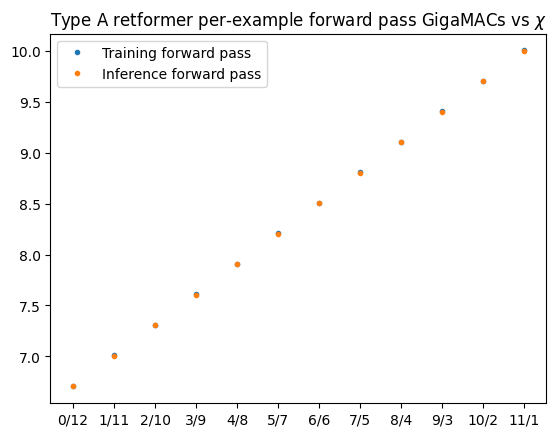

In [ ]:
import matplotlib.pyplot as plt

tick_labels = [f'{i}/{12-i}' for i in range(12)]

fig, ax = plt.subplots()

ax.plot(range(12), macs_A[:-1], '.', label="Training forward pass" )
ax.plot(range(12), macs_A_improved[:-1], '.' ,label="Inference forward pass" )


ax.set_xticks(range(12))
ax.set_xticklabels(tick_labels)
ax.legend()

ax.set_title(r"Type A retformer per-example forward pass GigaMACs vs $\chi$")

plt.show()

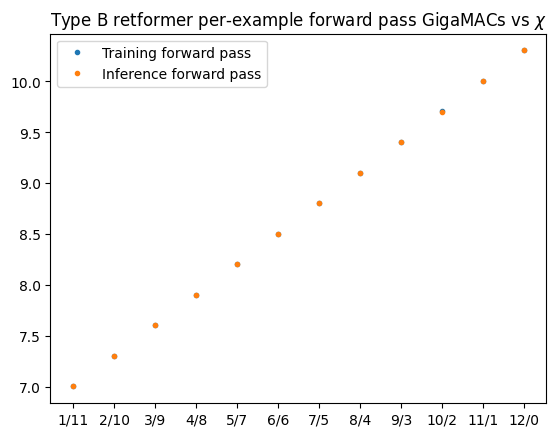

In [ ]:
import matplotlib.pyplot as plt

tick_labels = [f'{i}/{12-i}' for i in range(1,13)]

fig, ax = plt.subplots()

ax.plot(range(12), macs_B + [macs_A[-1]], '.', label="Training forward pass" )
ax.plot(range(12), macs_B_improved + [macs_A_improved[-1]], '.' ,label="Inference forward pass" )


ax.set_xticks(range(12))
ax.set_xticklabels(tick_labels)
ax.legend()

ax.set_title(r"Type B retformer per-example forward pass GigaMACs vs $\chi$")

plt.show()

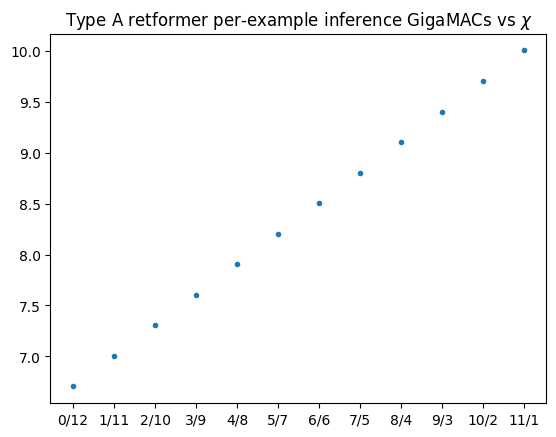

In [ ]:
import matplotlib.pyplot as plt

tick_labels = [f'{i}/{12-i}' for i in range(12)]

fig, ax = plt.subplots()

# ax.plot(range(12), macs_A[:-1], '.', label="Training forward pass" )
ax.plot(range(12), macs_A_improved[:-1], '.' ,label="Inference forward pass" )


ax.set_xticks(range(12))
ax.set_xticklabels(tick_labels)
# ax.legend()

ax.set_title(r"Type A retformer per-example inference GigaMACs vs $\chi$")

plt.show()

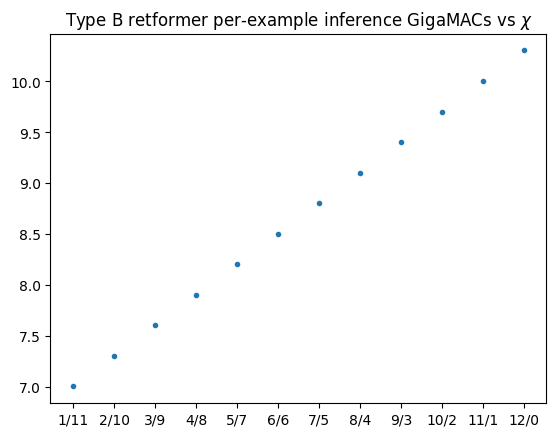

In [ ]:
import matplotlib.pyplot as plt

tick_labels = [f'{i}/{12-i}' for i in range(1,13)]

fig, ax = plt.subplots()

# ax.plot(range(12), macs_B + [macs_A[-1]], '.', label="Training forward pass" )
ax.plot(range(12), macs_B_improved + [macs_A_improved[-1]], '.' ,label="Inference forward pass" )


ax.set_xticks(range(12))
ax.set_xticklabels(tick_labels)
# ax.legend()

ax.set_title(r"Type B retformer per-example inference GigaMACs vs $\chi$")

plt.show()

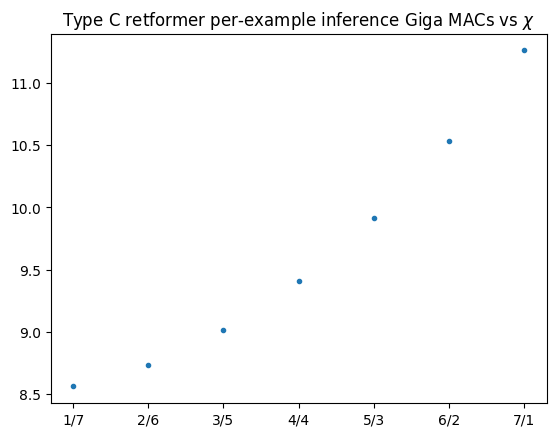

In [ ]:
macs_C = [8.562978048,
  8.731520256,
  9.012423936,
  9.405689088,
  9.911315712,
  10.529303808,
  11.259653376]
tick_labels = [f'{i}/{8-i}' for i in range(1, 8)]

fig, ax = plt.subplots()

ax.plot(range(1, 8), [ mac  for mac in macs_C], '.' )

ax.set_xticks(range(1, 8))
ax.set_xticklabels(tick_labels)

ax.set_title(r"Type C retformer per-example inference Giga MACs vs $\chi$")

plt.show()

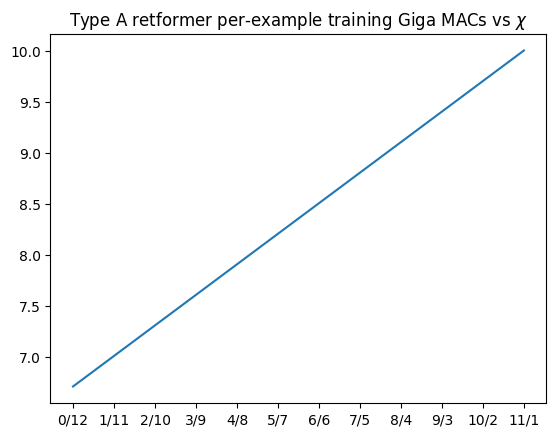

In [ ]:
import matplotlib.pyplot as plt

tick_labels = [f'{i}/{12-i}' for i in range(12)]

fig, ax = plt.subplots()

ax.plot(range(12), [ mac / 1e9 for mac in macs_A[:-1]] )

ax.set_xticks(range(12))
ax.set_xticklabels(tick_labels)

ax.set_title(r"Type A retformer per-example training Giga MACs vs $\chi$")

plt.show()


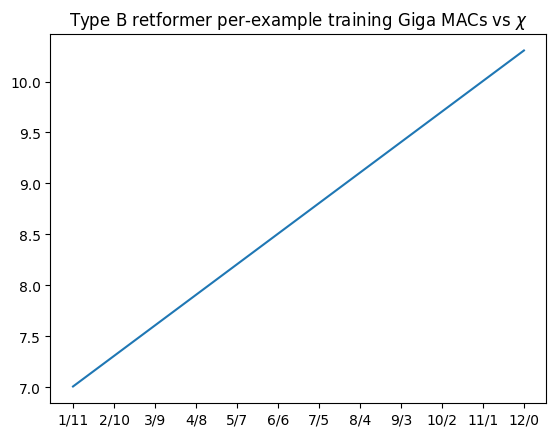

In [ ]:
tick_labels = [f'{i}/{12-i}' for i in range(1, 13)]

fig, ax = plt.subplots()

ax.plot(range(12), [ mac / 1e9 for mac in macs_B][::-1] + [macs_A[-1] / 1e9] )

ax.set_xticks(range(12))
ax.set_xticklabels(tick_labels)

ax.set_title(r"Type B retformer per-example training Giga MACs vs $\chi$")

plt.show()

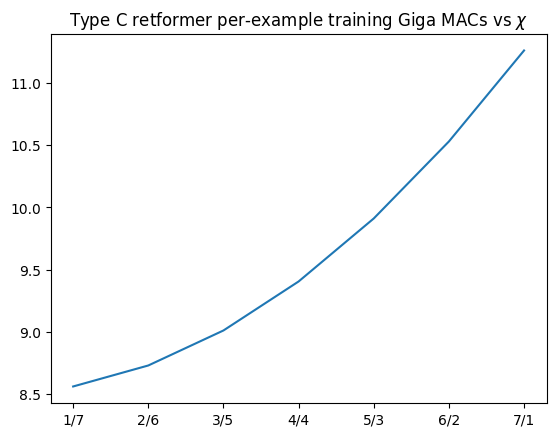

In [ ]:
tick_labels = [f'{i}/{8-i}' for i in range(1, 8)]

fig, ax = plt.subplots()

ax.plot(range(1, 8), [ mac / 1e9 for mac in macs_C] )

ax.set_xticks(range(1, 8))
ax.set_xticklabels(tick_labels)

ax.set_title(r"Type C retformer per-example training Giga MACs vs $\chi$")

plt.show()

In [ ]:
import wandb
# net_param goes 1 to 7 for type C
# 0 to 12 for type A
# 1 to 11 for type B
LR1 = 1e-3
WEIGHTDECAY = 0.05
NUMEPOCHS = 10
def train_model(net_type, net_param):
  wandb.init(project=f"2_{net_type}_{net_param}")
  if net_type == 'C':
    net = ZombieRetformer(12, 768, 768, 8, vocab_size, 0.2, num_attn=net_param).to(device)
  elif net_type == 'A':
    net = Retformer(12, 768, 768, 8, vocab_size, 0.2, binary_vector=('0' * net_param + '1' * (12 - net_param))).to(device)
  else:
    net = Retformer(12, 768, 768, 8, vocab_size, 0.2, binary_vector=('1' * net_param + '0' * (12 - net_param))).to(device)
  optimizer = torch.optim.AdamW(net.parameters(), lr=LR1, weight_decay=WEIGHTDECAY)
  criterion = nn.CrossEntropyLoss(reduction='mean')
  train_loader = DataLoader(train_set, batch_size=BATCH_SIZE)
  for i in range(NUMEPOCHS):
    print(f"epoch {i+1}")
    net.train()
    for x, target in tqdm.tqdm(train_loader):
        x, target = x.to(device), target.to(device)

        optimizer.zero_grad()
        pred = net(x)
        loss = criterion(pred.view(-1, vocab_size), target.view(-1))
        wandb.log({'loss': loss.item()})
        loss.backward()
        optimizer.step()
    net.eval()
    train_perpl = evaluate(net, train_loader, vocab_size)
    print("Train perplexity:", train_perpl)
    wandb.log({"train_perplexity": train_perpl})
  wandb.finish()

In [ ]:
for net_param in range(13):
  train_model('A', net_param)
for net_param in range(1, 12):
  train_model('B', net_param)
for net_param in range(1,8):
  train_model('C', net_param)

loss,█▆▆▆▆▅▅▆▅▅▅▄▄▄▅▄▄▄▄▄▄▄▄▄▄▃▄▃▃▃▃▄▁▁▁▁
train_perplexity,▁
loss,5.58314
train_perplexity,468.06134


epoch 1


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 285.7641217336236
epoch 2


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 148.08097945229517
epoch 3


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 99.56240995146162
epoch 4


100%|██████████| 64/64 [01:04<00:00,  1.02s/it]


Train perplexity: 84.06364993843152
epoch 5


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 60.82412251122239
epoch 6


100%|██████████| 64/64 [01:05<00:00,  1.03s/it]


Train perplexity: 52.81239762599931
epoch 7


100%|██████████| 64/64 [01:05<00:00,  1.03s/it]


Train perplexity: 46.22654427193259
epoch 8


100%|██████████| 64/64 [01:05<00:00,  1.03s/it]


Train perplexity: 34.91677946697395
epoch 9


100%|██████████| 64/64 [01:06<00:00,  1.03s/it]


Train perplexity: 30.065708673798543
epoch 10


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 23.9842810087078


loss,█▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁
train_perplexity,█▄▃▃▂▂▂▁▁▁
loss,3.08765
train_perplexity,23.98428


epoch 1


100%|██████████| 64/64 [01:04<00:00,  1.01s/it]


Train perplexity: 270.7638138673199
epoch 2


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 133.7449071375951
epoch 3


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 102.66586323248683
epoch 4


100%|██████████| 64/64 [01:05<00:00,  1.03s/it]


Train perplexity: 57.77601124589687
epoch 5


100%|██████████| 64/64 [01:05<00:00,  1.03s/it]


Train perplexity: 43.876666677597846
epoch 6


100%|██████████| 64/64 [01:05<00:00,  1.03s/it]


Train perplexity: 34.533046665842235
epoch 7


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 31.77272476939639
epoch 8


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 21.33832501495922
epoch 9


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 13.59482654317213
epoch 10


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 13.425516928186843


loss,█▇▇▆▅▅▅▄▄▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
train_perplexity,█▄▃▂▂▂▁▁▁▁
loss,2.66732
train_perplexity,13.42552


epoch 1


100%|██████████| 64/64 [01:04<00:00,  1.00s/it]


Train perplexity: 280.2922805096253
epoch 2


100%|██████████| 64/64 [01:04<00:00,  1.01s/it]


Train perplexity: 125.27679044125631
epoch 3


100%|██████████| 64/64 [01:04<00:00,  1.01s/it]


Train perplexity: 79.96182414612282
epoch 4


100%|██████████| 64/64 [01:04<00:00,  1.01s/it]


Train perplexity: 66.5903948166333
epoch 5


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 42.76524811808558
epoch 6


100%|██████████| 64/64 [01:04<00:00,  1.01s/it]


Train perplexity: 39.095162767997465
epoch 7


100%|██████████| 64/64 [01:04<00:00,  1.01s/it]


Train perplexity: 30.677485767590916
epoch 8


100%|██████████| 64/64 [01:04<00:00,  1.01s/it]


Train perplexity: 16.635287088014568
epoch 9


100%|██████████| 64/64 [01:04<00:00,  1.01s/it]


Train perplexity: 11.098765116208497
epoch 10


100%|██████████| 64/64 [01:04<00:00,  1.01s/it]


Train perplexity: 34.81091696188897


loss,█▇▇▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▃▂▃▂▃▂▂▂▂▂▁▁▁▁▂▃
train_perplexity,█▄▃▂▂▂▂▁▁▂
loss,3.8125
train_perplexity,34.81092


epoch 1


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 286.2023315628888
epoch 2


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 146.04998267885207
epoch 3


100%|██████████| 64/64 [01:03<00:00,  1.00it/s]


Train perplexity: 85.83185174791375
epoch 4


100%|██████████| 64/64 [01:03<00:00,  1.00it/s]


Train perplexity: 60.64197471727455
epoch 5


100%|██████████| 64/64 [01:03<00:00,  1.00it/s]


Train perplexity: 46.017731996399164
epoch 6


100%|██████████| 64/64 [01:03<00:00,  1.00it/s]


Train perplexity: 34.24100779312265
epoch 7


100%|██████████| 64/64 [01:04<00:00,  1.00s/it]


Train perplexity: 23.011441791149945
epoch 8


100%|██████████| 64/64 [01:03<00:00,  1.00it/s]


Train perplexity: 29.865448803668876
epoch 9


100%|██████████| 64/64 [01:03<00:00,  1.00it/s]


Train perplexity: 12.764228230334869
epoch 10


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 6.942213257219828


loss,█▇▇▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▃▂▂▂▂▁▁▁
train_perplexity,█▄▃▂▂▂▁▂▁▁
loss,2.04407
train_perplexity,6.94221


epoch 1


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 278.9201821382168
epoch 2


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 136.02571254832895
epoch 3


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 99.69883151510204
epoch 4


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 61.3529946873715
epoch 5


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 44.970176936592686
epoch 6


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 45.07901090494946
epoch 7


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 19.93625588862121
epoch 8


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 16.716455739019953
epoch 9


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 7.5639356711052095
epoch 10


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 5.162447777708522


loss,█▇▆▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
train_perplexity,█▄▃▂▂▂▁▁▁▁
loss,1.90863
train_perplexity,5.16245


epoch 1


100%|██████████| 64/64 [01:02<00:00,  1.03it/s]


Train perplexity: 288.3974164120956
epoch 2


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 150.54133025615224
epoch 3


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 108.14580963730312
epoch 4


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 69.34894758105482
epoch 5


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 39.27687185714381
epoch 6


100%|██████████| 64/64 [01:03<00:00,  1.00it/s]


Train perplexity: 31.170292973959132
epoch 7


100%|██████████| 64/64 [01:03<00:00,  1.00it/s]


Train perplexity: 21.47350608783953
epoch 8


100%|██████████| 64/64 [01:03<00:00,  1.00it/s]


Train perplexity: 14.60236757022765
epoch 9


100%|██████████| 64/64 [01:04<00:00,  1.00s/it]


Train perplexity: 8.604213545043212
epoch 10


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 5.88521259746093


loss,█▆▆▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▃▃▂▂▂▂▃▂▂▂▂▁▂▁▁▁
train_perplexity,█▅▄▃▂▂▁▁▁▁
loss,1.96846
train_perplexity,5.88521


epoch 1


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 294.12791608746744
epoch 2


100%|██████████| 64/64 [01:01<00:00,  1.03it/s]


Train perplexity: 137.77783907331795
epoch 3


100%|██████████| 64/64 [01:02<00:00,  1.03it/s]


Train perplexity: 100.81402621420315
epoch 4


100%|██████████| 64/64 [01:02<00:00,  1.03it/s]


Train perplexity: 61.77693188366922
epoch 5


100%|██████████| 64/64 [01:02<00:00,  1.03it/s]


Train perplexity: 48.74951612387155
epoch 6


100%|██████████| 64/64 [01:02<00:00,  1.03it/s]


Train perplexity: 30.06855638545427
epoch 7


100%|██████████| 64/64 [01:02<00:00,  1.03it/s]


Train perplexity: 18.744824920230112
epoch 8


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 12.392835895764621
epoch 9


100%|██████████| 64/64 [01:02<00:00,  1.03it/s]


Train perplexity: 9.045409260604627
epoch 10


100%|██████████| 64/64 [01:02<00:00,  1.03it/s]


Train perplexity: 4.84464738624112


loss,█▇▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁
train_perplexity,█▄▃▂▂▂▁▁▁▁
loss,1.89045
train_perplexity,4.84465


epoch 1


100%|██████████| 64/64 [01:01<00:00,  1.05it/s]


Train perplexity: 326.2497750200564
epoch 2


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 152.44894351769855
epoch 3


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 88.6747321748252
epoch 4


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 62.05201237246444
epoch 5


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 45.5422290077057
epoch 6


100%|██████████| 64/64 [01:01<00:00,  1.03it/s]


Train perplexity: 36.3744751303168
epoch 7


100%|██████████| 64/64 [01:01<00:00,  1.03it/s]


Train perplexity: 17.592965225472028
epoch 8


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 11.579115066958696
epoch 9


100%|██████████| 64/64 [01:01<00:00,  1.03it/s]


Train perplexity: 6.379496492861888
epoch 10


100%|██████████| 64/64 [01:01<00:00,  1.03it/s]


Train perplexity: 4.363890975498416


loss,█▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
train_perplexity,█▄▃▂▂▂▁▁▁▁
loss,1.70392
train_perplexity,4.36389


epoch 1


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 335.68039791683714
epoch 2


100%|██████████| 64/64 [01:01<00:00,  1.05it/s]


Train perplexity: 153.9739978310377
epoch 3


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 106.97324580184508
epoch 4


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 71.56373118838444
epoch 5


100%|██████████| 64/64 [01:01<00:00,  1.05it/s]


Train perplexity: 49.75897134406447
epoch 6


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 27.219623092238876
epoch 7


100%|██████████| 64/64 [01:01<00:00,  1.05it/s]


Train perplexity: 16.68651401466945
epoch 8


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 11.023714174871468
epoch 9


100%|██████████| 64/64 [01:01<00:00,  1.05it/s]


Train perplexity: 6.254785493213703
epoch 10


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 4.291250068902338


loss,█▇▇▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
train_perplexity,█▄▃▂▂▁▁▁▁▁
loss,1.65358
train_perplexity,4.29125


epoch 1


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]


Train perplexity: 349.0484110264172
epoch 2


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 149.74336049782255
epoch 3


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 90.78416013269816
epoch 4


100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Train perplexity: 64.23552559300698
epoch 5


100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Train perplexity: 43.751158247065575
epoch 6


100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Train perplexity: 22.604164895956696
epoch 7


100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Train perplexity: 14.424484045473495
epoch 8


100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Train perplexity: 12.961735704879633
epoch 9


100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Train perplexity: 6.64260782769745
epoch 10


100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Train perplexity: 3.954978031206093


loss,█▇▆▆▅▅▅▄▄▄▄▄▄▃▃▃▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
train_perplexity,█▄▃▂▂▁▁▁▁▁
loss,1.68092
train_perplexity,3.95498


epoch 1


100%|██████████| 64/64 [00:59<00:00,  1.08it/s]


Train perplexity: 355.99944710005013
epoch 2


100%|██████████| 64/64 [01:00<00:00,  1.07it/s]


Train perplexity: 157.9865467816384
epoch 3


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 91.73562030827895
epoch 4


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 73.59964157309784
epoch 5


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 46.17939565687463
epoch 6


100%|██████████| 64/64 [01:01<00:00,  1.05it/s]


Train perplexity: 29.364051756845804
epoch 7


100%|██████████| 64/64 [01:01<00:00,  1.05it/s]


Train perplexity: 15.922014013910518
epoch 8


100%|██████████| 64/64 [01:01<00:00,  1.05it/s]


Train perplexity: 8.94245730840956
epoch 9


100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Train perplexity: 5.001060987165789
epoch 10


100%|██████████| 64/64 [01:01<00:00,  1.05it/s]


Train perplexity: 3.209386665681978


loss,█▇▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▁▁▁▁▁
train_perplexity,█▄▃▂▂▂▁▁▁▁
loss,1.50289
train_perplexity,3.20939


epoch 1


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 417.70624242847043
epoch 2


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 193.52124210319167
epoch 3


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 139.26446782221254
epoch 4


100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Train perplexity: 74.0141587533407
epoch 5


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 46.96515278759373
epoch 6


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 33.51107978983233
epoch 7


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 19.04037237831996
epoch 8


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 11.393032961967828
epoch 9


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 7.726785744310599
epoch 10


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 4.762290328015158


loss,█▇▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train_perplexity,█▄▃▂▂▁▁▁▁▁
loss,1.77513
train_perplexity,4.76229


epoch 1


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 399.36981629966334
epoch 2


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]


Train perplexity: 182.47567319729913
epoch 3


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]


Train perplexity: 99.55728989825987
epoch 4


100%|██████████| 64/64 [00:59<00:00,  1.08it/s]


Train perplexity: 68.60828838622102
epoch 5


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]


Train perplexity: 64.03253768621016
epoch 6


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]


Train perplexity: 29.009837072677715
epoch 7


100%|██████████| 64/64 [00:59<00:00,  1.08it/s]


Train perplexity: 20.40365142971607
epoch 8


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]


Train perplexity: 11.182053971344963
epoch 9


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]


Train perplexity: 7.938005218297794
epoch 10


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]


Train perplexity: 4.250911425303662


loss,█▇▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
train_perplexity,█▄▃▂▂▁▁▁▁▁
loss,1.75546
train_perplexity,4.25091


epoch 1


100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Train perplexity: 345.0834676787733
epoch 2


100%|██████████| 64/64 [01:00<00:00,  1.07it/s]


Train perplexity: 151.164584946589
epoch 3


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 89.95146082980003
epoch 4


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 67.23603799618732
epoch 5


100%|██████████| 64/64 [01:00<00:00,  1.07it/s]


Train perplexity: 55.211292924477654
epoch 6


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 31.34608658984143
epoch 7


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 20.376834300995554
epoch 8


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 10.79984816168695
epoch 9


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 7.884480238089745
epoch 10


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 4.806640524214895


loss,█▆▆▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
train_perplexity,█▄▃▂▂▂▁▁▁▁
loss,1.69069
train_perplexity,4.80664


epoch 1


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 320.7824357322696
epoch 2


100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Train perplexity: 148.86794318708303
epoch 3


100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Train perplexity: 100.67994325364012
epoch 4


100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Train perplexity: 62.33086223504103
epoch 5


100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Train perplexity: 46.196491610571385
epoch 6


100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Train perplexity: 32.08024238346028
epoch 7


100%|██████████| 64/64 [01:01<00:00,  1.05it/s]


Train perplexity: 17.48484004864789
epoch 8


100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Train perplexity: 14.068051630987846
epoch 9


100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Train perplexity: 8.183992029888595
epoch 10


100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Train perplexity: 5.226486877329063


loss,█▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_perplexity,█▄▃▂▂▂▁▁▁▁
loss,1.88046
train_perplexity,5.22649


epoch 1


100%|██████████| 64/64 [01:01<00:00,  1.03it/s]


Train perplexity: 377.3951726987423
epoch 2


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 169.6835893081994
epoch 3


100%|██████████| 64/64 [01:01<00:00,  1.05it/s]


Train perplexity: 94.71321971728315
epoch 4


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 73.89338739231913
epoch 5


100%|██████████| 64/64 [01:01<00:00,  1.05it/s]


Train perplexity: 54.31177101371651
epoch 6


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 30.8359191687453
epoch 7


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 26.525677235971532
epoch 8


100%|██████████| 64/64 [01:01<00:00,  1.05it/s]


Train perplexity: 12.52575168817933
epoch 9


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 7.858258528870723
epoch 10


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 5.309926698353969


loss,█▇▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
train_perplexity,█▄▃▂▂▁▁▁▁▁
loss,1.97378
train_perplexity,5.30993


epoch 1


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 313.8521908699384
epoch 2


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 140.73013563360306
epoch 3


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 94.79064793839606
epoch 4


100%|██████████| 64/64 [01:01<00:00,  1.03it/s]


Train perplexity: 69.54960595280065
epoch 5


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 45.500418686463554
epoch 6


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 36.72676140575198
epoch 7


100%|██████████| 64/64 [01:02<00:00,  1.03it/s]


Train perplexity: 17.836174662620063
epoch 8


100%|██████████| 64/64 [01:01<00:00,  1.03it/s]


Train perplexity: 11.666100519839192
epoch 9


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 8.670328061106996
epoch 10


100%|██████████| 64/64 [01:01<00:00,  1.03it/s]


Train perplexity: 4.740451037577444


loss,█▆▆▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
train_perplexity,█▄▃▂▂▂▁▁▁▁
loss,1.74724
train_perplexity,4.74045


epoch 1


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 278.3714114569256
epoch 2


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 123.92907130744436
epoch 3


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 81.30580738983645
epoch 4


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 56.816528677380326
epoch 5


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 60.536212979673564
epoch 6


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 24.343292639146135
epoch 7


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 14.565124883447783
epoch 8


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 11.896471835131988
epoch 9


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 6.590688032346748
epoch 10


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 4.809591529315207


loss,█▆▆▆▅▅▄▄▄▄▄▃▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train_perplexity,█▄▃▂▂▁▁▁▁▁
loss,1.8347
train_perplexity,4.80959


epoch 1


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 278.28903991050964
epoch 2


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 124.67301053693339
epoch 3


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 86.69547785245811
epoch 4


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 71.60921704883499
epoch 5


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 46.66894828433926
epoch 6


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 36.73869188927292
epoch 7


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 24.225334028919303
epoch 8


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 16.018453481450987
epoch 9


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 10.862072175678238
epoch 10


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 8.345063642764252


loss,█▆▆▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
train_perplexity,█▄▃▃▂▂▁▁▁▁
loss,2.29608
train_perplexity,8.34506


epoch 1


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 274.2493105646539
epoch 2


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 129.80930380202165
epoch 3


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 92.425737981638
epoch 4


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 87.06186112658112
epoch 5


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 55.871976102107276
epoch 6


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 32.231812014079
epoch 7


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 24.441636475089318
epoch 8


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 18.934202186135185
epoch 9


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 15.378698518807253
epoch 10


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 10.549274623459862


loss,█▆▆▆▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁
train_perplexity,█▄▃▃▂▂▁▁▁▁
loss,2.53655
train_perplexity,10.54927


epoch 1


100%|██████████| 64/64 [01:04<00:00,  1.00s/it]


Train perplexity: 276.5864293005942
epoch 2


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 141.69925771065712
epoch 3


100%|██████████| 64/64 [01:04<00:00,  1.00s/it]


Train perplexity: 84.51850329158353
epoch 4


100%|██████████| 64/64 [01:03<00:00,  1.00it/s]


Train perplexity: 67.55559639342671
epoch 5


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 42.97428860231829
epoch 6


100%|██████████| 64/64 [01:03<00:00,  1.00it/s]


Train perplexity: 33.049195901766105
epoch 7


100%|██████████| 64/64 [01:04<00:00,  1.00s/it]


Train perplexity: 28.251556889304403
epoch 8


100%|██████████| 64/64 [01:04<00:00,  1.00s/it]


Train perplexity: 17.956185023690757
epoch 9


100%|██████████| 64/64 [01:04<00:00,  1.00s/it]


Train perplexity: 16.154761056192584
epoch 10


100%|██████████| 64/64 [01:04<00:00,  1.00s/it]


Train perplexity: 11.826326415549675


loss,█▇▆▆▅▅▄▄▄▄▃▄▃▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁
train_perplexity,█▄▃▂▂▂▁▁▁▁
loss,2.45229
train_perplexity,11.82633


epoch 1


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 270.6448165144585
epoch 2


100%|██████████| 64/64 [01:04<00:00,  1.01s/it]


Train perplexity: 126.51074571930334
epoch 3


100%|██████████| 64/64 [01:04<00:00,  1.01s/it]


Train perplexity: 85.2377180108107
epoch 4


100%|██████████| 64/64 [01:04<00:00,  1.01s/it]


Train perplexity: 63.9861571664101
epoch 5


100%|██████████| 64/64 [01:04<00:00,  1.01s/it]


Train perplexity: 52.80296683741783
epoch 6


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 33.17644329560112
epoch 7


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 24.138912502142293
epoch 8


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 16.204403931554605
epoch 9


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 12.123225076636556
epoch 10


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 7.508043943910285


loss,█▆▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
train_perplexity,█▄▃▃▂▂▁▁▁▁
loss,2.17124
train_perplexity,7.50804


epoch 1


100%|██████████| 64/64 [01:05<00:00,  1.03s/it]


Train perplexity: 258.82406082945323
epoch 2


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 123.7694239757201
epoch 3


100%|██████████| 64/64 [01:04<00:00,  1.01s/it]


Train perplexity: 84.94057503512956
epoch 4


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 56.01133888583081
epoch 5


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 49.225724485751314
epoch 6


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 31.0988180646154
epoch 7


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 20.782265979335243
epoch 8


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 19.542177770347582
epoch 9


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 12.035625232050682
epoch 10


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 9.482844815163205


loss,█▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▁▁▁
train_perplexity,█▄▃▂▂▂▁▁▁▁
loss,2.46622
train_perplexity,9.48284


epoch 1


100%|██████████| 64/64 [01:06<00:00,  1.04s/it]


Train perplexity: 290.12404302393026
epoch 2


100%|██████████| 64/64 [01:05<00:00,  1.03s/it]


Train perplexity: 126.54155293531872
epoch 3


100%|██████████| 64/64 [01:05<00:00,  1.03s/it]


Train perplexity: 84.06487603727604
epoch 4


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 69.68704732223216
epoch 5


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 58.16247729383126
epoch 6


100%|██████████| 64/64 [01:05<00:00,  1.03s/it]


Train perplexity: 38.57987505661185
epoch 7


100%|██████████| 64/64 [01:05<00:00,  1.03s/it]


Train perplexity: 28.529679299756967
epoch 8


100%|██████████| 64/64 [01:05<00:00,  1.03s/it]


Train perplexity: 30.20260397289565
epoch 9


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 18.64905194474319
epoch 10


100%|██████████| 64/64 [01:05<00:00,  1.03s/it]


Train perplexity: 12.725394878182207


loss,█▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁
train_perplexity,█▄▃▂▂▂▁▁▁▁
loss,2.60584
train_perplexity,12.72539


epoch 1


100%|██████████| 64/64 [01:10<00:00,  1.09s/it]


Train perplexity: 294.46559604887767
epoch 2


100%|██████████| 64/64 [01:09<00:00,  1.09s/it]


Train perplexity: 228.33042989674834
epoch 3


100%|██████████| 64/64 [01:09<00:00,  1.09s/it]


Train perplexity: 152.6200887146754
epoch 4


100%|██████████| 64/64 [01:09<00:00,  1.09s/it]


Train perplexity: 134.2450063238521
epoch 5


100%|██████████| 64/64 [01:09<00:00,  1.09s/it]


Train perplexity: 104.47976046828298
epoch 6


100%|██████████| 64/64 [01:09<00:00,  1.09s/it]


Train perplexity: 101.41421645564941
epoch 7


100%|██████████| 64/64 [01:09<00:00,  1.09s/it]


Train perplexity: 78.49780345627514
epoch 8


100%|██████████| 64/64 [01:09<00:00,  1.09s/it]


Train perplexity: 53.214462171072455
epoch 9


100%|██████████| 64/64 [01:10<00:00,  1.10s/it]


Train perplexity: 51.1327357244031
epoch 10


100%|██████████| 64/64 [01:10<00:00,  1.10s/it]


Train perplexity: 40.775280108410314


loss,█▆▆▆▄▄▄▄▄▄▅▃▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂
train_perplexity,█▆▄▄▃▃▂▁▁▁
loss,4.04601
train_perplexity,40.77528


epoch 1


100%|██████████| 64/64 [01:05<00:00,  1.03s/it]


Train perplexity: 290.5448762670858
epoch 2


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 200.2266057211468
epoch 3


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 227.26145440450233
epoch 4


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 142.15672365266624
epoch 5


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 143.0125220599951
epoch 6


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 149.6239006402699
epoch 7


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 6.044915409742416e+65
epoch 8


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 4.144569537289559e+19
epoch 9


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 87264.88309301763
epoch 10


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 13002.333941875033


loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂█▅▄▂▂▂▁▁▁▁▁▁
train_perplexity,▁▁▁▁▁▁ █▁▁
loss,13.87356
train_perplexity,13002.33394


epoch 1


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Train perplexity: 278.4697510541064
epoch 2


100%|██████████| 64/64 [01:02<00:00,  1.03it/s]


Train perplexity: 175.52381381606554
epoch 3


100%|██████████| 64/64 [01:01<00:00,  1.03it/s]


Train perplexity: 1.3165733683852444e+18
epoch 4


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 327913.25907284755
epoch 5


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 35682.9628314982
epoch 6


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 302.66422940247844
epoch 7


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 259.5596539488769
epoch 8


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 205.5765443759379
epoch 9


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 138.81317011667596
epoch 10


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Train perplexity: 119.67293901785655


loss,▂▁▁▁▁▁▁▁▁▁▃█▅▂▂▃▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_perplexity,▁▁█▁▁▁▁▁▁▁
loss,4.92421
train_perplexity,119.67294


epoch 1


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 286.29049916854797
epoch 2


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 150.2875378040344
epoch 3


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]


Train perplexity: 7.086576310482124e+20
epoch 4


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]


Train perplexity: 27113.18904113919
epoch 5


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 1209.04588006674
epoch 6


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 483.6236769910498
epoch 7


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 366.40327269253254
epoch 8


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 261.5431516084753
epoch 9


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 460.08995237385886
epoch 10


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 206.80883618727214


loss,▁▁▁▁▁▁▁▁▁▁▃█▇▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_perplexity,▁▁█▁▁▁▁▁▁▁
loss,5.4759
train_perplexity,206.80884


epoch 1


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 308.5485515786869
epoch 2


100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Train perplexity: 1457391.214478508
epoch 3


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 455.65253854293564
epoch 4


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 238.86260271813921
epoch 5


100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Train perplexity: 178.89675653434998
epoch 6


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 140.17436716593087
epoch 7


100%|██████████| 64/64 [01:01<00:00,  1.05it/s]


Train perplexity: 107.18289062193035
epoch 8


100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Train perplexity: 104.31784705372341
epoch 9


100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Train perplexity: 90.57431483868633
epoch 10


100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Train perplexity: 72.80135329720551


loss,▃▂▂▂▂█▅▇▅▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_perplexity,▁█▁▁▁▁▁▁▁▁
loss,4.24381
train_perplexity,72.80135


epoch 1


100%|██████████| 64/64 [01:03<00:00,  1.02it/s]


Train perplexity: 1184.4387972244685
epoch 2


100%|██████████| 64/64 [01:02<00:00,  1.03it/s]


Train perplexity: 322.80230090693397
epoch 3


100%|██████████| 64/64 [01:02<00:00,  1.03it/s]


Train perplexity: 188.39497637259706
epoch 4


100%|██████████| 64/64 [01:02<00:00,  1.03it/s]


Train perplexity: 132.32874558966114
epoch 5


100%|██████████| 64/64 [01:02<00:00,  1.03it/s]


Train perplexity: 111.49721013942317
epoch 6


100%|██████████| 64/64 [01:01<00:00,  1.03it/s]


Train perplexity: 78.6176786518987
epoch 7


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 83.22832010694951
epoch 8


100%|██████████| 64/64 [01:02<00:00,  1.03it/s]


Train perplexity: 78.80812642480126
epoch 9


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 90.25459476293233
epoch 10


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Train perplexity: 52.354162743581504


loss,▄█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_perplexity,█▃▂▁▁▁▁▁▁▁
loss,3.77788
train_perplexity,52.35416


epoch 1


100%|██████████| 64/64 [01:06<00:00,  1.04s/it]


Train perplexity: 1549.3171476074563
epoch 2


100%|██████████| 64/64 [01:05<00:00,  1.03s/it]


Train perplexity: 394.97648707022194
epoch 3


100%|██████████| 64/64 [01:05<00:00,  1.03s/it]


Train perplexity: 259.17348617805027
epoch 4


100%|██████████| 64/64 [01:05<00:00,  1.03s/it]


Train perplexity: 182.89822682877337
epoch 5


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Train perplexity: 133.73604436436224
epoch 6


100%|██████████| 64/64 [01:05<00:00,  1.03s/it]


Train perplexity: 105.86487154228297
epoch 7


100%|██████████| 64/64 [01:05<00:00,  1.03s/it]


Train perplexity: 92.92802827512286
epoch 8


100%|██████████| 64/64 [01:05<00:00,  1.03s/it]


Train perplexity: 69.69589395833809
epoch 9


100%|██████████| 64/64 [01:05<00:00,  1.03s/it]


Train perplexity: 62.44046203318832
epoch 10


100%|██████████| 64/64 [01:05<00:00,  1.03s/it]


Train perplexity: 56.121855159993885


loss,▃█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_perplexity,█▃▂▂▁▁▁▁▁▁
loss,3.79643
train_perplexity,56.12186
